## 필요한 모듈 설치 확인

In [1]:
# 본 코드는 https://github.com/kyungjaelee/Deep-Reinforcement-Learning를 베이스로 합니다.

!python3 -c 'import numpy'
!python3 -c 'import matplotlib'
!python3 -c 'import seaborn'
!python3 -c 'import torch'

# 만약 gym이 안깔려있으면

# !sudo apt-get install -y python-pyglet python3-opengl zlib1g-dev libjpeg-dev patchelf \
#       cmake swig libboost-all-dev libsdl2-dev libosmesa6-dev xvfb ffmpeg
# !git clone https://github.com/openai/gym.git
# !cd gym
# !pip install -e '.[atari]'

!python3 -c 'import gym'

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## OpenAI gym 환경 가져오기

In [3]:
env = gym.make('FrozenLake8x8-v0')

# FrozenLake의 상태공간
obs_space = env.observation_space
n_state = obs_space.n
print('Observation space')
print("Total {} states".format(n_state))

# FrozenLake의 행동공간
act_space = env.action_space
n_act = act_space.n
print('Action space')
print("Total {} actions".format(n_act))

# FrozenLake의 전이확률
P = env.unwrapped.P
env.render()

Observation space
Total 64 states
Action space
Total 4 actions

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


* 이렇게 State space와 action space가 모두 셀 수 있는 MDP를 'Grid world'라고 부릅니다.
* Policy iteration과 value iteration은 이러한 Grid world에만 적용할 수 있습니다.(?)

## 정책 초기화하기

Initial Policy Distribution:



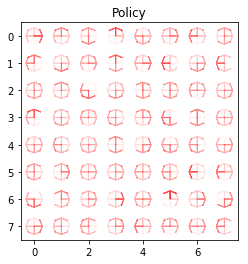

In [4]:
def plot_policy(policy):
    plt.figure(num=0)
    plt.imshow(np.ones((8,8,3)))
    plt.title("Policy")  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.show()
    
'''
문제 : 임의로 정책을 초기화해서 policy 변수에 저장해주세요
힌트 : 임의로 초기화할때는 np.random.uniform 함수를 쓰고, 정책이 확률분포인 점에 유의하세요.
'''

np.set_printoptions(precision=3,suppress=True)
print("Initial Policy Distribution:\n")
plot_policy(policy)

## 정책 평가

In [5]:
def policy_evaluation(env, policy, gamma = 0.99, epsilon = 1e-6):
    '''
    env : gym environment
    gamma : discount factor
    epsilon : terminal condition
    '''
    
    # 환경 정보 가져오기
    obs_space = env.observation_space
    n_state = obs_space.n
    P = env.unwrapped.P    
    
    # 임의로 상태가치함수 초기화
    v = np.random.uniform(size=(n_state,1))
    
    while True:
        # v_prime은 일관성 조건의 target을 의미합니다.
        v_prime = np.zeros((n_state,))
        for s in P.keys():
            for a in P[s].keys():
                for prob, next_s, reward, done in P[s][a]:
                    v_prime[s] += (reward + gamma*v[next_s])*prob*policy[s][a]    
        dist = np.max(np.abs(v-v_prime))
        v = v_prime
        # 충분히 가깝지 않으면 계속 반복합니다.
        if dist < epsilon:
            break
    return v

def plot_results(policy, value): # For visualization
    plt.figure(num=0)
    plt.imshow(np.reshape(value,(8,8)))
    plt.title("Value Function")  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.show()

Policy evaluation for random policy

Value of current policy:


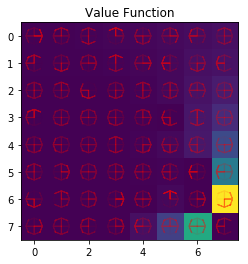

In [6]:
print('Policy evaluation for random policy\n')
value = policy_evaluation(env, policy, gamma = 0.99, epsilon = 1e-6)
print('Value of current policy:')
plot_results(policy, value)

## 정책 개선

In [7]:
def policy_improvement(env, v, gamma = 0.99):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    q = np.zeros((n_state,n_act))
    
    # 현재 정책에서 가장 가치가 높은 행동들로 greedy update를 합니다.
    for s in P.keys():
        for a in P[s].keys():
            for prob, next_s, reward, done in P[s][a]:
                q[s,a] += (reward + gamma*v[next_s])*prob
                    
    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy

Policy improvement

Improved Policy:


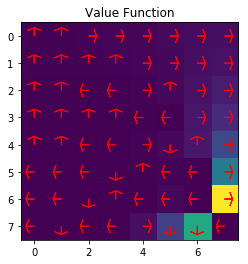

In [8]:
print('Policy improvement\n')
policy = policy_improvement(env, value)
print('Improved Policy:')
plot_results(policy, value)

## 정책 반복

In [9]:
def policy_iteration(env):
    policy = np.random.uniform(size=(n_state,n_act))
    policy = policy/np.sum(policy,axis=1,keepdims=True)

    while True:
        value = policy_evaluation(env, policy)
        policy_prime = policy_improvement(env, value)

        if (policy == policy_prime).all():
            break
        policy = policy_prime
    
    return policy, value

Policy Iteration
Computation Time : 2.93


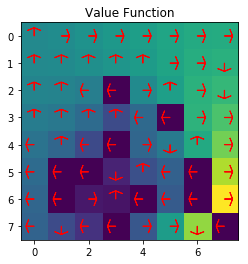

In [10]:
print("Policy Iteration")
import time
start = time.time()
policy, value = policy_iteration(env)
print("Computation Time : %.2f"%(time.time() - start))
plot_results(policy, value)

## 테스트

In [11]:
obs = env.reset()
for t in range(10000):
    print('t = %d'%t)
    env.render()
    print('')
    action = np.random.choice(n_act, 1, p=policy[obs][:])[0]
    next_obs, reward, done, info = env.step(action)
    obs = next_obs
    if done:
        break
env.render()
env.close()

t = 0

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 1
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 2
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 3
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 4
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 5
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 6
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 7
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 8
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 9
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 10
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 11
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFF

## 정책 반복

In [13]:
def value_iteration(env,gamma=0.99,epsilon=1e-6):
    
    # 환경 정보 가져오기
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    P = env.unwrapped.P

    # 상태 가치 함수를 임의로 초기화
    value = np.random.uniform(size=(n_state,1))
    
    while True: 
        '''
        문제 : 가치반복의 반복 단계를 구현하세요.
        힌트 : 정책반복의 반복 단계를 참고하세요. 
        가치 반복단계에서 각 상태의 가치는 행동 가치 함수 중 가장 가치가 높은 행동만을 가집니다.(늘 최선을 다합니다.)
        '''
            
    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy, value

def plot_results(policy, value):
    plt.figure(num=0)
    plt.imshow(np.reshape(value,(8,8)))
    plt.title("Value Function")  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.show()

Value Iteration Compact
Computation Time : 0.47



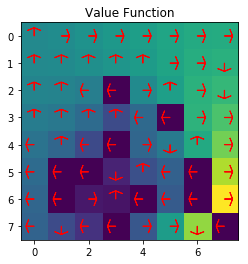

In [15]:
print("Value Iteration Compact")
import time
start = time.time()
policy, value = value_iteration(env)
print("Computation Time : %.2f"%(time.time() - start))
print('')

plot_results(policy, value)
np.set_printoptions(precision=3,suppress=True)

## 테스트

In [16]:
obs = env.reset()
for t in range(10000):
    print('t = %d'%t)
    env.render()
    print('')
    action = np.random.choice(n_act, 1, p=policy[obs][:])[0]
    next_obs, reward, done, info = env.step(action)
    obs = next_obs
    if done:
        break
env.render()
env.close()

t = 0

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 1
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 2
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 3
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 4
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 5
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 6
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 7
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 8
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 9
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 10
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 11
  (Right)
SFFFFFFF
FFFFFF